## Importing the Modules

In [5]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow 
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization, Dense, MaxPooling2D, Input, Activation
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam,Adagrad,Adamax
import time as tm
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression

Importing the dataset

In [6]:
dataset = "C:\\Users\\mayan\\Desktop\\CODES\\PYTHON\\Null Codes\\ResNet50\\DATASET"

## Collecting the age of every image, and making an array

In [7]:
ages = []

photos = os.listdir(dataset)
for file in photos:
    if file[0].isdigit():
        dob = file.split('_')[1]
        birthYear = dob.split('-')[0]
        photo_taken = int(file.split('_')[2][:4])

        age = photo_taken - int(birthYear)
        ages.append(age)
indexs=[]
for i,num in enumerate(ages):
    if ((num>100) or (num<0)):
        indexs.append(i)
        del ages[i]
print(len(ages))

9590


In [8]:
ages = np.array(ages)
np.save('ages.npy', ages)
print(ages.shape)

(9590,)


In [9]:
ages = ages.reshape(-1)
print(ages)

[28 39 60 ... 37 55 42]


## Preprocessing the images in the dataset and coverting it to an array

In [10]:
images = []
start = tm.time()
for photo in photos:
    image_path = os.path.join(dataset, photo)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    images.append(image)
print(f"Completed in {int((tm.time() - start)/60)} minutes")
print(len(images))

Completed in 0 minutes
10000


Removing the ages that have age as more than 100 or less than 0

In [11]:
for index in indexs:
    del images[index]
images.pop(-1)
images.pop(-1)
print(len(images))

9590


In [12]:
images = np.array(images)
np.save('images.npy', images)
images.shape

(9590, 224, 224, 3)

## Importing the ResNet50 Model

In [13]:
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
age_output = Dense(1, activation='linear')(x)  # Linear activation for age regression

model = Model(inputs=base_model.input, outputs=age_output)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 25,633,793 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
prediction = model.predict(images)

300/300 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step


In [15]:
prediction = prediction.reshape(-1,1)
ages = ages.reshape(-1,1)
print("Ages:\n",ages)
print("Predtion of the model:\n",prediction)

Ages:
 [[28]
 [39]
 [60]
 ...
 [37]
 [55]
 [42]]
Predtion of the model:
 [[ 0.2358371 ]
 [ 0.5241882 ]
 [ 0.32070756]
 ...
 [-0.15361726]
 [ 0.47669   ]
 [-0.27936763]]


## Using another model to find relation between prediction and the actual ages

Training and predicting the Regressor Model

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)

rf_regressor.fit(prediction, ages.ravel())

pred = rf_regressor.predict(prediction)

Printing the Predicted Age

In [17]:
pred = pred.astype(int)
print(pred)
model.save('age_prediction_model.h5')

[34 45 50 ... 38 46 39]


Evaluating the model

In [18]:
mae = mean_absolute_error(ages, pred)
print(f"Mean Absolute Error: {mae:.3f}")

r2 = r2_score(ages, pred)
print(f"R-squared: {r2:.2f}")

Mean Absolute Error: 6.423
R-squared: 0.71


## Data Visualisation of the Model Evaluation

Closer the blue dots are to the red line, more accurate is the prediction

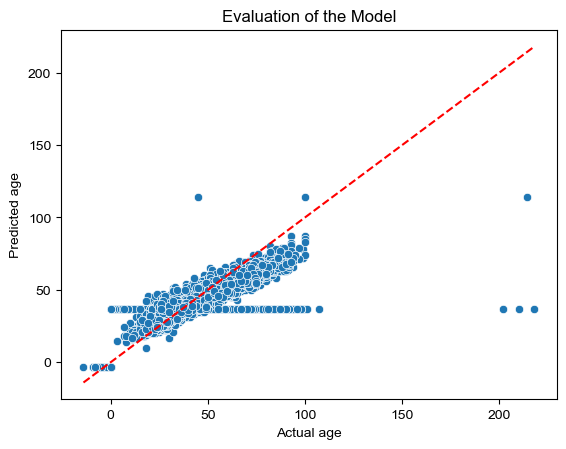

In [19]:
df = pd.DataFrame({'Actual': ages.reshape(-1), 'Predicted': pred.reshape(-1)})
sns.scatterplot(x='Actual',y='Predicted',data=df)
min_age = min(np.min(ages), np.min(pred))
max_age = max(np.max(ages), np.max(pred))
plt.plot([min_age, max_age], [min_age, max_age], color='red', linestyle='--')
plt.xlabel('Actual age')
plt.ylabel('Predicted age')
plt.title('Evaluation of the Model')
sns.set_theme(style='darkgrid')
plt.show()